In [15]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.Collecting tensorflow
     ------------------------------------ 385.0/385.0 MB 310.0 kB/s eta 0:00:00
     -------------------------------------- 71.9/71.9 kB 246.8 kB/s eta 0:00:00
     -------------------------------------- 26.4/26.4 MB 617.4 kB/s eta 0:00:00
     ------------------------------------ 413.4/413.4 kB 318.5 kB/s eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 745.1 kB/s eta 0:00:00
     -------------------------------------- 57.5/57.5 kB 749.7 kB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 859.5 kB/s eta 0:00:00
     ------------------------------------ 126.6/126.6 kB 373.1 kB/s eta 0:00:00
     ---------------------------------------- 4.4/4.4 MB 640.1 kB/s eta 0:00:00
     ------------------------------------ 133.7/133.7 kB 525.4 kB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 325.8 kB/s eta 0:00:00
     ----------------------------

In [5]:
pip install opencv-python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:

def loading_preprocessing(image_dir, img_size=(224, 224)):
    data = []
    
    # Loop through each image in the directory
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        
        # Read image
        img = cv2.imread(img_path)
        if img is not None:
            # Convert to grayscale (optional, based on your requirement)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Apply CLAHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img_clahe = clahe.apply(img)
            
            # Resize the image
            img_resized = cv2.resize(img_clahe, img_size)
            
            # Normalize the pixel values
            img_resized = img_resized / 255.0
            
            # Append the processed image to the data list
            data.append(img_resized)
    
    # Convert the list to a NumPy array and return
    return np.array(data)

In [3]:
# Path to NORMAL and PNEUMONIA images
train_class1 = loading_preprocessing('C:/Users/pulak/Downloads/TRY/chest_xray/train/NORMAL', img_size=(224, 224))
train_class2 = loading_preprocessing('C:/Users/pulak/Downloads/TRY/chest_xray/train/PNEUMONIA', img_size=(224, 224))

print("Normal images shape:", train_class1.shape)
print("Pneumonia images shape:", train_class2.shape)


Normal images shape: (1341, 224, 224)
Pneumonia images shape: (3875, 224, 224)


In [4]:
# Labels for NORMAL (0) and PNEUMONIA (1)
labels_class1 = np.zeros((train_class1.shape[0], 1))  # Label 0 for NORMAL
labels_class2 = np.ones((train_class2.shape[0], 1))   # Label 1 for PNEUMONIA

# Combine the images and labels
X_train = np.concatenate([train_class1, train_class2], axis=0)
y_train = np.concatenate([labels_class1, labels_class2], axis=0)

# If using a CNN, you may need to reshape the images to include the channel dimension
X_train = X_train.reshape(-1, 224, 224, 1)  # Add a channel dimension for grayscale images

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)

Training data shape: (5216, 224, 224, 1)
Training labels shape: (5216, 1)


In [17]:
from tensorflow.keras.applications import InceptionV3, ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained models
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model_resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to add new layers on top of the base model
def add_new_last_layer(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create the models with the added layers for pneumonia classification (2 classes: pneumonia, normal)
model_inception = add_new_last_layer(base_model_inception, 2)
model_resnet = add_new_last_layer(base_model_resnet, 2)

# Freeze base models to avoid retraining the base layers
for layer in base_model_inception.layers:
    layer.trainable = False
for layer in base_model_resnet.layers:
    layer.trainable = False

# Compile models
model_inception.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the CLAHE function
def apply_clahe(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img_gray)

# Set your input and output paths
input_folder_normal = 'C:/Users/pulak/Downloads/TRY/chest_xray/train/NORMAL'
input_folder_pneumonia = 'C:/Users/pulak/Downloads/TRY/chest_xray/train/PNEUMONIA'
output_folder_normal = 'C:/Users/pulak/Downloads/TRY/preprocessed/NORMAL'
output_folder_pneumonia = 'C:/Users/pulak/Downloads/TRY/preprocessed/PNEUMONIA'

# Create directories if they don't exist
os.makedirs(output_folder_normal, exist_ok=True)
os.makedirs(output_folder_pneumonia, exist_ok=True)

# Function to apply CLAHE and resize images in a folder
def preprocess_and_save(input_folder, output_folder, img_size=(224, 224)):
    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img_clahe = apply_clahe(img)
            img_resized = cv2.resize(img_clahe, img_size)  # Resize for ResNet50V2
            output_path = os.path.join(output_folder, img_name)
            cv2.imwrite(output_path, img_resized)

# Preprocess images in both NORMAL and PNEUMONIA folders
preprocess_and_save(input_folder_normal, output_folder_normal)
preprocess_and_save(input_folder_pneumonia, output_folder_pneumonia)

print("Preprocessing completed. Images saved in the output folders.")


Preprocessing completed. Images saved in the output folders.


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Set up ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2  # Use 20% of the data for validation
)

# Load training and validation data from the preprocessed folder
train_generator = train_datagen.flow_from_directory(
    'C:/Users/pulak/Downloads/TRY/preprocessed',  # Path to the preprocessed folder
    target_size=(299, 299),  # Change to (224, 224) for ResNet50V2
    batch_size=32,
    class_mode='categorical',
    subset='training'  # For training data
)

val_generator = train_datagen.flow_from_directory(
    'C:/Users/pulak/Downloads/TRY/preprocessed',  # Path to the preprocessed folder
    target_size=(299, 299),  # Change to (224, 224) for ResNet50V2
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # For validation data
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [22]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Clear the session to reset the model state
K.clear_session()

# Load pre-trained ResNet50V2 model (without the top layers)
base_model_resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for classification
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(2, activation='softmax')(x)  # Output layer with 2 classes (NORMAL and PNEUMONIA)

# Create the complete model
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)

# **Freeze the layers in the base model** so they are not trained again
for layer in base_model_resnet.layers:
    layer.trainable = False

# Compile the model after freezing the layers
model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary to check the architecture
model_resnet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 56, 56, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 56, 56, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 58, 58, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 25,665,026 (97.90 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [23]:
# Train ResNet50V2 model
history_resnet = model_resnet.fit(
    train_generator_resnet,
    validation_data=val_generator_resnet,
    epochs=50,
    steps_per_epoch=train_generator_resnet.samples // 32,
    validation_steps=val_generator_resnet.samples // 32
)


Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.8954 - loss: 0.2999 - val_accuracy: 0.9443 - val_loss: 0.1377
Epoch 2/50
  1/130 ━━━━━━━━━━━━━━━━━━━━ 3:04 1s/step - accuracy: 0.9375 - loss: 0.0673

C:\Users\pulak\anaconda3\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9375 - loss: 0.0673 - val_accuracy: 0.9474 - val_loss: 0.1671
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9478 - loss: 0.1363 - val_accuracy: 0.9492 - val_loss: 0.1303
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8750 - loss: 0.2018 - val_accuracy: 0.9474 - val_loss: 0.1223
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.9363 - loss: 0.1479 - val_accuracy: 0.9512 - val_loss: 0.1168
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9062 - loss: 0.1287 - val_accuracy: 0.9474 - val_loss: 0.2000
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.9547 - loss: 0.1191 - val_accuracy: 0.9609 - val_loss: 0.1163
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9688 - loss: 0.0558 - val_accuracy: 1.0000 - val_loss: 0.0196
Epoch 9/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.9517 - loss: 0.1137 - val_accuracy: 0.9551 - 

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate InceptionV3 on test set
Y_pred_inception = model_inception.predict(val_generator)
y_pred_inception = np.argmax(Y_pred_inception, axis=1)
print('Classification Report for InceptionV3')
print(classification_report(val_generator.classes, y_pred_inception, target_names=val_generator.class_indices.keys()))


33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step
Classification Report for InceptionV3
              precision    recall  f1-score   support

      NORMAL       0.25      0.27      0.26       268
   PNEUMONIA       0.74      0.72      0.73       775

    accuracy                           0.60      1043
   macro avg       0.50      0.49      0.49      1043
weighted avg       0.61      0.60      0.61      1043



In [27]:
# Evaluate ResNet50V2 on validation set
Y_pred_resnet = model_resnet.predict(val_generator_resnet)  # Use val_generator_resnet
y_pred_resnet = np.argmax(Y_pred_resnet, axis=1)

# Print classification report for ResNet50V2
from sklearn.metrics import classification_report
print('Classification Report for ResNet50V2')
print(classification_report(val_generator_resnet.classes, y_pred_resnet, target_names=val_generator_resnet.class_indices.keys()))


33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
Classification Report for ResNet50V2
              precision    recall  f1-score   support

      NORMAL       0.28      0.29      0.28       268
   PNEUMONIA       0.75      0.73      0.74       775

    accuracy                           0.62      1043
   macro avg       0.51      0.51      0.51      1043
weighted avg       0.63      0.62      0.62      1043



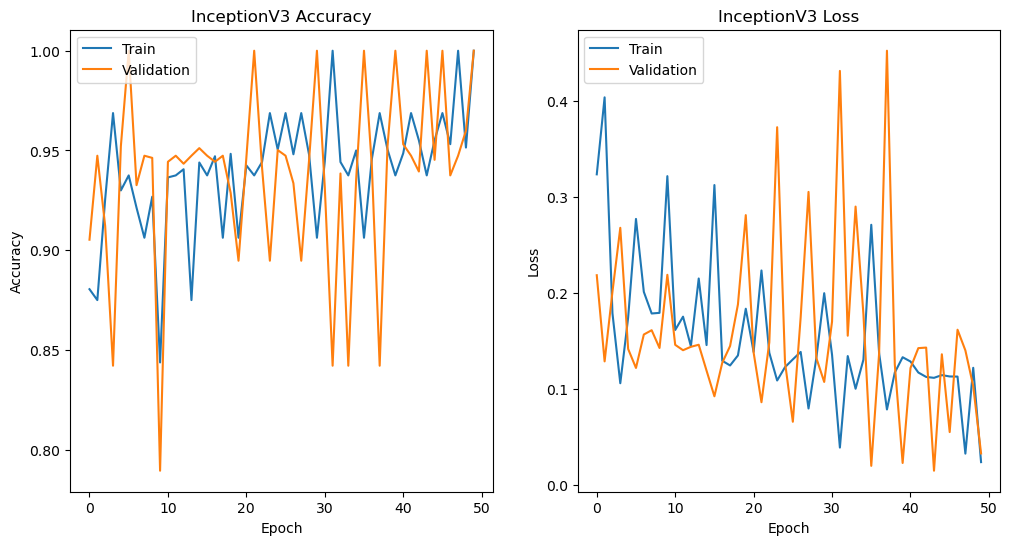

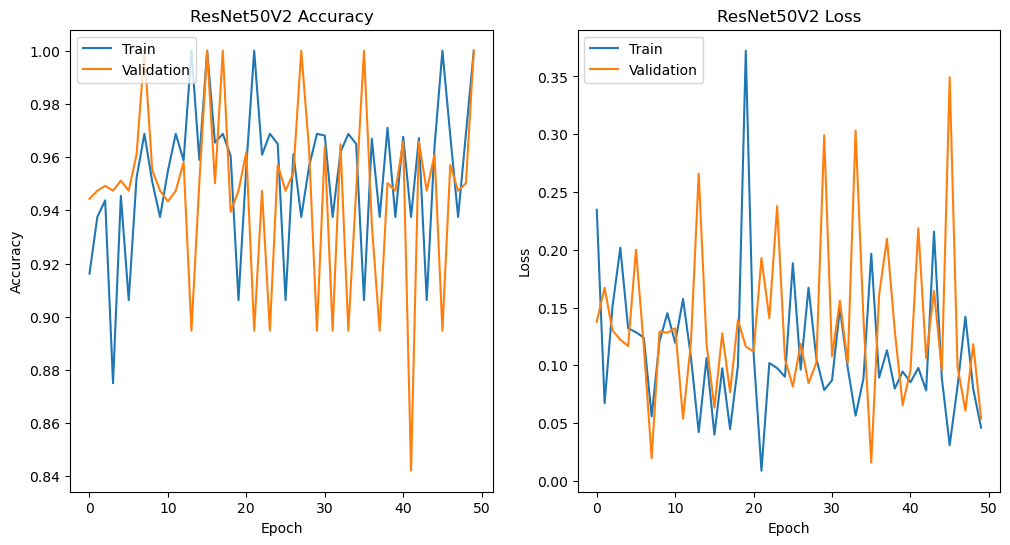

In [28]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss curves
def plot_metrics(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

# Plot metrics for InceptionV3
plot_metrics(history_inception, 'InceptionV3')

# Plot metrics for ResNet50V2
plot_metrics(history_resnet, 'ResNet50V2')


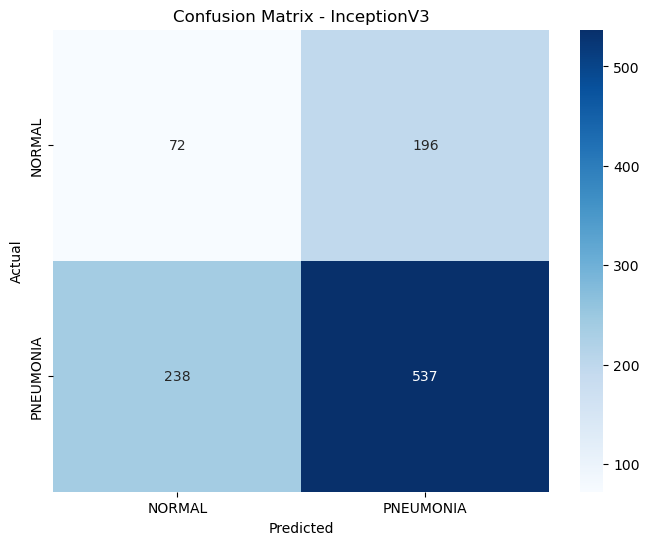

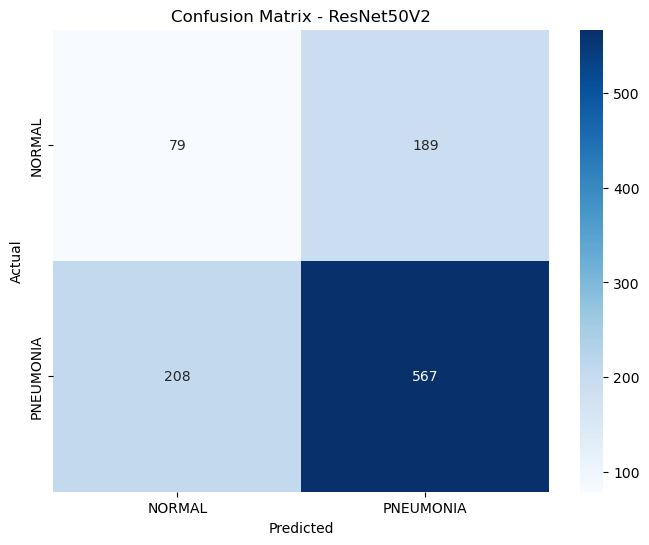

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix for InceptionV3
cm_inception = confusion_matrix(val_generator.classes, y_pred_inception)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_inception, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix - InceptionV3')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Confusion Matrix for ResNet50V2
cm_resnet = confusion_matrix(val_generator.classes, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix - ResNet50V2')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
accuracy = accuracy_score(val_generator_resnet.classes, y_pred_inception)
precision = precision_score(val_generator_resnet.classes, y_pred_inception)
recall = recall_score(val_generator_resnet.classes, y_pred_inception)
f1 = f1_score(val_generator_resnet.classes, y_pred_inception)

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
accuracy = accuracy_score(val_generator_resnet.classes, y_pred_resnet)
precision = precision_score(val_generator_resnet.classes, y_pred_resnet)
recall = recall_score(val_generator_resnet.classes, y_pred_resnet)
f1 = f1_score(val_generator_resnet.classes, y_pred_resnet)

In [41]:
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.62


In [42]:
print(f'Precision: {precision:.2f}')

Precision: 0.75


In [43]:
print(f'Recall: {recall:.2f}')

Recall: 0.73


33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step


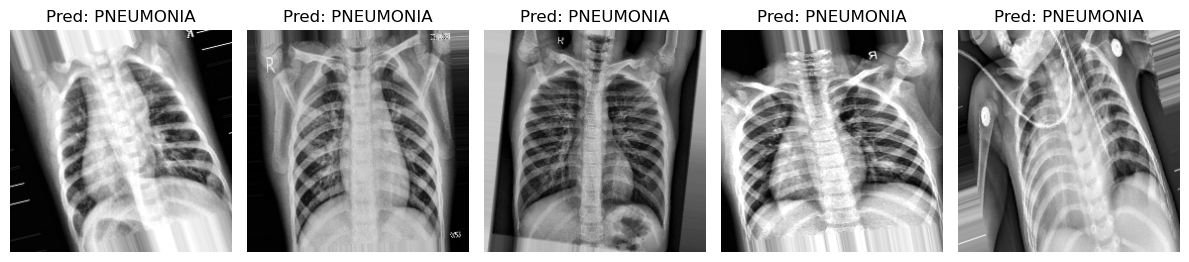

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve actual images from the validation generator
x_val, y_val_true = next(val_generator_resnet)  # Get a batch of images and their true labels
y_pred_inception = np.argmax(model_inception.predict(val_generator_resnet), axis=1)

# Plot the last 5 images in the batch along with their predicted labels
plt.figure(figsize=(12, 8))
for i in range(5):  # Adjust this to plot more or fewer images as needed
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_val[i])  # Display the actual image
    
    # Set title according to the predicted label
    if y_pred_inception[i] == 0:
        title = "NORMAL"
    else:
        title = "PNEUMONIA"
    
    plt.title(title)
    plt.axis('off')  # Turn off axis labels for clarity
plt.tight_layout()
plt.show()
